## KNN-Based Two-Stage Fruit & Vegetable Classifier

This notebook implements a two-stage classification pipeline using
K-Nearest Neighbors (KNN). The same MobileNetV2 feature extractor and
PCA dimensionality reduction used in the SVM experiment are reused here
to ensure a fair comparison.


In [1]:
import torch
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np

from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import os 



In [2]:
# -------------------- Image preprocessing --------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# -------------------- Paths --------------------
base_dir = os.path.dirname(os.getcwd())  # fruit_veg_classifier/
train_dir = os.path.join(base_dir, "train")
test_dir  = os.path.join(base_dir, "test")

print("Base directory:", base_dir)

# ============================================================
# STAGE 1: PARENT LOADERS (Fruit vs Vegetable)
# ============================================================
# Point to 'train'. Classes will be ['fruit', 'vegetable']
train_dataset_stage1 = ImageFolder(train_dir, transform=transform)
test_dataset_stage1  = ImageFolder(test_dir, transform=transform)

train_loader_stage1 = DataLoader(train_dataset_stage1, batch_size=32, shuffle=False)
test_loader_stage1  = DataLoader(test_dataset_stage1,  batch_size=32, shuffle=False)

print("\nStage 1 Classes (Parent):", train_dataset_stage1.classes)


# ============================================================
# STAGE 2: CHILD LOADERS (Specific Types)
# ============================================================
# We need separate loaders to get the specific class names (Apple, Banana...)

# Paths to sub-folders
fruit_train_dir = os.path.join(train_dir, 'fruit')
fruit_test_dir  = os.path.join(test_dir, 'fruit')
veg_train_dir   = os.path.join(train_dir, 'vegetable')
veg_test_dir    = os.path.join(test_dir, 'vegetable')

# 1. Fruit Loaders
train_dataset_fruits = ImageFolder(fruit_train_dir, transform=transform)
test_dataset_fruits  = ImageFolder(fruit_test_dir, transform=transform)

train_loader_fruits = DataLoader(train_dataset_fruits, batch_size=32, shuffle=False)
test_loader_fruits  = DataLoader(test_dataset_fruits, batch_size=32, shuffle=False)

# 2. Vegetable Loaders
train_dataset_vegs = ImageFolder(veg_train_dir, transform=transform)
test_dataset_vegs  = ImageFolder(veg_test_dir, transform=transform)

train_loader_vegs = DataLoader(train_dataset_vegs, batch_size=32, shuffle=False)
test_loader_vegs  = DataLoader(test_dataset_vegs, batch_size=32, shuffle=False)

print("\nStage 2 Fruit Classes:", train_dataset_fruits.classes)
print("Stage 2 Veg Classes:", train_dataset_vegs.classes)

Base directory: c:\Users\Hams\Downloads\machine-learning\MLproject\fruit_veg_classifier

Stage 1 Classes (Parent): ['fruit', 'vegetable']

Stage 2 Fruit Classes: ['apple', 'banana', 'grapes', 'kiwi', 'mango', 'pineapple', 'pomegranate', 'watermelon']
Stage 2 Veg Classes: ['beetroot', 'bell pepper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'jalepeno', 'lemon', 'lettuce', 'onion', 'orange', 'paprika', 'pear', 'peas', 'potato', 'raddish', 'soy beans', 'spinach', 'sweetcorn', 'sweetpotato', 'tomato', 'turnip']


In [3]:
# Load pretrained MobileNetV2
model = models.mobilenet_v2(pretrained=True)
feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])
feature_extractor.eval()  # freeze weights

# Function to extract features
def extract_features(loader):
    features_list, labels_list = [], []
    with torch.no_grad():
        for images, labels in loader:
            outputs = feature_extractor(images)
            outputs = outputs.view(outputs.size(0), -1)
            features_list.append(outputs.numpy())
            labels_list.append(labels.numpy())
    return np.concatenate(features_list), np.concatenate(labels_list)

# -------------------- A. Stage 1: Parent Features --------------------
print("\n--- STAGE 1: PARENT (Fruit vs Veg) ---")
X_train_parent, y_train_parent = extract_features(train_loader_stage1)
X_test_parent,  y_test_parent  = extract_features(test_loader_stage1)

# -------------------- B. Stage 2: Child Features --------------------
# We extract specifically from the sub-loaders to get the correct labels (0=Apple, etc.)

print("\n--- STAGE 2: FRUIT CHILD ---")
X_train_fruit, y_train_fruit = extract_features(train_loader_fruits)
X_test_fruit,  y_test_fruit  = extract_features(test_loader_fruits)

print("\n--- STAGE 2: VEGETABLE CHILD ---")
X_train_veg, y_train_veg = extract_features(train_loader_vegs)
X_test_veg,  y_test_veg  = extract_features(test_loader_vegs)

print("\nFeature Extraction Complete!")
print(f"Parent Train Shape: {X_train_parent.shape}")
print(f"Fruit Train Shape:  {X_train_fruit.shape}")
print(f"Veg Train Shape:    {X_train_veg.shape}")

c:\Users\Hams\Downloads\machine-learning\MLproject\fruit_veg_classifier\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Hams\Downloads\machine-learning\MLproject\fruit_veg_classifier\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



--- STAGE 1: PARENT (Fruit vs Veg) ---


c:\Users\Hams\Downloads\machine-learning\MLproject\fruit_veg_classifier\venv\lib\site-packages\PIL\Image.py:1034: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



--- STAGE 2: FRUIT CHILD ---

--- STAGE 2: VEGETABLE CHILD ---

Feature Extraction Complete!
Parent Train Shape: (3115, 62720)
Fruit Train Shape:  (679, 62720)
Veg Train Shape:    (2436, 62720)


In [4]:

# -------------------- Dimensionality Reduction (PCA) --------------------
# KNN struggles with high dimensions (Curse of Dimensionality).
# Reducing from 1280 -> 150 usually improves accuracy and speed.
N_COMPONENTS = 150 

# ============================================================
# 1. PARENT PCA (Fruit vs Veg)
# ============================================================
pca_parent = PCA(n_components=N_COMPONENTS)

X_train_parent_pca = pca_parent.fit_transform(X_train_parent)
X_test_parent_pca  = pca_parent.transform(X_test_parent)
print(f"Parent PCA done. Shape: {X_train_parent_pca.shape}")

# ============================================================
# 2. FRUIT CHILD PCA (Apple vs Banana...)
# ============================================================
pca_fruit = PCA(n_components=N_COMPONENTS)

X_train_fruit_pca = pca_fruit.fit_transform(X_train_fruit)
X_test_fruit_pca  = pca_fruit.transform(X_test_fruit)
print(f"Fruit PCA done. Shape: {X_train_fruit_pca.shape}")

# ============================================================
# 3. VEGETABLE CHILD PCA (Carrot vs Potato...)
# ============================================================
pca_veg = PCA(n_components=N_COMPONENTS)

X_train_veg_pca = pca_veg.fit_transform(X_train_veg)
X_test_veg_pca  = pca_veg.transform(X_test_veg)
print(f"Veg PCA done. Shape: {X_train_veg_pca.shape}")


Parent PCA done. Shape: (3115, 150)
Fruit PCA done. Shape: (679, 150)
Veg PCA done. Shape: (2436, 150)


In [5]:


# -------------------- Stage 1: Parent KNN (Fruit vs Vegetable) --------------------

print("Training Stage 1 KNN (Parent)...")

# 1. Initialize KNN
# n_neighbors=5 is standard. weights='distance' helps if classes are slightly imbalanced.
knn_stage1 = KNeighborsClassifier(n_neighbors=5, weights="distance", metric="euclidean")

# 2. Fit on Parent PCA Data
# Note: We use the variables from the previous PCA cell
knn_stage1.fit(X_train_parent_pca, y_train_parent)

# 3. Predict on Test Set
y_pred_stage1 = knn_stage1.predict(X_test_parent_pca)

# 4. Evaluate
print(f"Stage 1 Accuracy: {accuracy_score(y_test_parent, y_pred_stage1)*100:.2f}%")
print("\nConfusion Matrix (Fruit vs Veg):\n", confusion_matrix(y_test_parent, y_pred_stage1))
print("\nClassification Report:\n", classification_report(
    y_test_parent, y_pred_stage1, target_names=train_dataset_stage1.classes))

Training Stage 1 KNN (Parent)...
Stage 1 Accuracy: 96.38%

Confusion Matrix (Fruit vs Veg):
 [[ 76  13]
 [  0 270]]

Classification Report:
               precision    recall  f1-score   support

       fruit       1.00      0.85      0.92        89
   vegetable       0.95      1.00      0.98       270

    accuracy                           0.96       359
   macro avg       0.98      0.93      0.95       359
weighted avg       0.97      0.96      0.96       359



In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# -------------------- Stage 2: Train the Child KNNs --------------------

# ============================================================
# PART A: FRUIT SPECIALIST
# ============================================================
print("="*60)
print(f"TRAINING FRUIT KNN (Classes: {len(train_dataset_fruits.classes)})")
print("="*60)

# 1. Initialize & Train
knn_fruit = KNeighborsClassifier(n_neighbors=5, weights="distance", metric="euclidean")
knn_fruit.fit(X_train_fruit_pca, y_train_fruit)

# 2. Predict & Evaluate
y_pred_fruit = knn_fruit.predict(X_test_fruit_pca)

print(f"Fruit KNN Accuracy: {accuracy_score(y_test_fruit, y_pred_fruit)*100:.2f}%")
print("\nClassification Report (Fruit):\n", classification_report(
    y_test_fruit, 
    y_pred_fruit, 
    labels=list(range(len(train_dataset_fruits.classes))), # Safety fix for class mismatch
    target_names=train_dataset_fruits.classes
))


# ============================================================
# PART B: VEGETABLE SPECIALIST
# ============================================================
print("\n" + "="*60)
print(f"TRAINING VEGETABLE KNN (Classes: {len(train_dataset_vegs.classes)})")
print("="*60)

# 1. Initialize & Train
knn_veg = KNeighborsClassifier(n_neighbors=5, weights="distance", metric="euclidean")
knn_veg.fit(X_train_veg_pca, y_train_veg)

# 2. Predict & Evaluate
y_pred_veg = knn_veg.predict(X_test_veg_pca)

print(f"Veg KNN Accuracy: {accuracy_score(y_test_veg, y_pred_veg)*100:.2f}%")
print("\nClassification Report (Veg):\n", classification_report(
    y_test_veg, 
    y_pred_veg, 
    labels=list(range(len(train_dataset_vegs.classes))), # Safety fix for class mismatch
    target_names=train_dataset_vegs.classes
))

TRAINING FRUIT KNN (Classes: 8)
Fruit KNN Accuracy: 52.81%

Classification Report (Fruit):
               precision    recall  f1-score   support

       apple       0.83      1.00      0.91        10
      banana       1.00      0.78      0.88         9
      grapes       1.00      1.00      1.00        10
        kiwi       0.83      1.00      0.91        10
       mango       0.56      1.00      0.71        10
   pineapple       0.00      0.00      0.00        10
 pomegranate       0.00      0.00      0.00        10
  watermelon       0.00      0.00      0.00        10

   micro avg       0.53      0.59      0.56        79
   macro avg       0.53      0.60      0.55        79
weighted avg       0.52      0.59      0.55        79


TRAINING VEGETABLE KNN (Classes: 28)
Veg KNN Accuracy: 58.15%

Classification Report (Veg):
                precision    recall  f1-score   support

     beetroot       1.00      1.00      1.00        10
  bell pepper       1.00      1.00      1.00        

c:\Users\Hams\Downloads\machine-learning\MLproject\fruit_veg_classifier\venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Hams\Downloads\machine-learning\MLproject\fruit_veg_classifier\venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Hams\Downloads\machine-learning\MLproject\fruit_veg_classifier\venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter

In [9]:

# -------------------- Final Hierarchical Predictions (KNN) --------------------
print("Running Hierarchical KNN Inference on Test Set...")

# 1. Create the Global Class List (Fruits + Vegs sorted)
all_classes = sorted(train_dataset_fruits.classes + train_dataset_vegs.classes)
class_to_idx = {cls_name: i for i, cls_name in enumerate(all_classes)}

y_pred_final_indices = []
y_true_final_indices = []

# Loop over ALL test samples (Parent Test Set contains everything)
for i in range(len(X_test_parent)):
    
    # --- A. Prepare Data ---
    # Get raw feature (1280 dimensions)
    raw_feature = X_test_parent[i].reshape(1, -1)
    
    # Get TRUE label from file path
    path, _ = test_dataset_stage1.samples[i]
    true_classname = os.path.basename(os.path.dirname(path))
    
    # Safety: Skip if class is not in our training set
    if true_classname not in class_to_idx:
        continue
        
    y_true_final_indices.append(class_to_idx[true_classname])

    # --- B. Hierarchical Logic ---
    
    # 1. Ask Parent: Fruit (0) or Veg (1)?
    # Note: We must transform raw_feature using PARENT PCA first
    parent_feat = pca_parent.transform(raw_feature)
    parent_decision = knn_stage1.predict(parent_feat)[0]
    
    predicted_classname = ""
    
    if parent_decision == 0: 
        # === Branch: FRUIT ===
        # 1. Transform raw feature using FRUIT PCA
        child_feat = pca_fruit.transform(raw_feature)
        
        # 2. Predict using Fruit KNN
        local_id = knn_fruit.predict(child_feat)[0]
        
        # 3. Get Name
        predicted_classname = train_dataset_fruits.classes[local_id]
        
    else:
        # === Branch: VEGETABLE ===
        # 1. Transform raw feature using VEG PCA
        child_feat = pca_veg.transform(raw_feature)
        
        # 2. Predict using Veg KNN
        local_id = knn_veg.predict(child_feat)[0]
        
        # 3. Get Name
        predicted_classname = train_dataset_vegs.classes[local_id]

    # Convert name back to Global ID and store
    y_pred_final_indices.append(class_to_idx[predicted_classname])

# Convert to numpy arrays
y_true = np.array(y_true_final_indices)
y_pred = np.array(y_pred_final_indices)

# -------------------- Evaluate Final Predictions --------------------

# 1. Accuracy
final_accuracy = accuracy_score(y_true, y_pred)
print(f"Final KNN Hierarchical Accuracy: {final_accuracy*100:.2f}%")

# 2. Confusion Matrix
print("\nFinal Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

# 3. Classification Report
print("\nFinal Classification Report:\n", classification_report(y_true, y_pred, target_names=all_classes))

Running Hierarchical KNN Inference on Test Set...
Final KNN Hierarchical Accuracy: 98.05%

Final Confusion Matrix:
 [[ 9  0  0 ...  1  0  0]
 [ 0  7  0 ...  0  0  0]
 [ 0  0 10 ...  0  0  0]
 ...
 [ 0  0  0 ... 10  0  0]
 [ 0  0  0 ...  0 10  0]
 [ 0  0  0 ...  0  0 10]]

Final Classification Report:
                precision    recall  f1-score   support

        apple       1.00      0.90      0.95        10
       banana       1.00      0.78      0.88         9
     beetroot       1.00      1.00      1.00        10
  bell pepper       1.00      1.00      1.00        10
      cabbage       1.00      1.00      1.00        10
     capsicum       1.00      1.00      1.00        10
       carrot       1.00      0.90      0.95        10
  cauliflower       1.00      1.00      1.00        10
chilli pepper       1.00      1.00      1.00        10
         corn       0.82      0.90      0.86        10
     cucumber       1.00      1.00      1.00        10
     eggplant       1.00      1.00  

In [12]:
import random
import os

# -------------------- Simple Random KNN Testing --------------------

# 1. Pick 15 random indices from the Parent Test Set
indices = random.sample(range(len(X_test_parent)), 15)

print(f"{'TRUE LABEL':<15} | {'PREDICTED':<15} | {'BRANCH':<10} | {'STATUS'}")
print("-" * 65)

correct_count = 0

for i in indices:
    # --- A. Get Raw Feature ---
    # We take the raw MobileNet feature (1280 dims)
    raw_feature = X_test_parent[i].reshape(1, -1)
    
    # --- B. Get True Name ---
    path = test_dataset_stage1.samples[i][0]
    true_name = os.path.basename(os.path.dirname(path))
    
    # --- C. Hierarchical Prediction ---
    
    # 1. Ask Parent: Fruit or Veg?
    # MUST apply Parent PCA first!
    parent_feat = pca_parent.transform(raw_feature)
    parent_decision = knn_stage1.predict(parent_feat)[0]
    
    pred_name = "Unknown"
    branch = "?"
    
    if parent_decision == 0:
        # === Branch: FRUIT ===
        branch = "Fruit"
        # 2. Apply FRUIT PCA
        child_feat = pca_fruit.transform(raw_feature)
        # 3. Predict Fruit KNN
        local_id = knn_fruit.predict(child_feat)[0]
        pred_name = train_dataset_fruits.classes[local_id]
        
    else:
        # === Branch: VEGETABLE ===
        branch = "Veg"
        # 2. Apply VEG PCA
        child_feat = pca_veg.transform(raw_feature)
        # 3. Predict Veg KNN
        local_id = knn_veg.predict(child_feat)[0]
        pred_name = train_dataset_vegs.classes[local_id]

    # --- D. Compare ---
    if true_name == pred_name:
        status = "success"
        correct_count += 1
    else:
        status = "fail"

    print(f"{true_name:<15} | {pred_name:<15} | {branch:<10} | {status}")

# Final Score
print("-" * 65)
print(f"Batch Accuracy: {correct_count}/15 ({(correct_count/15)*100:.1f}%)")

TRUE LABEL      | PREDICTED       | BRANCH     | STATUS
-----------------------------------------------------------------
beetroot        | beetroot        | Veg        | success
sweetcorn       | sweetcorn       | Veg        | success
beetroot        | beetroot        | Veg        | success
apple           | apple           | Fruit      | success
cauliflower     | cauliflower     | Veg        | success
cabbage         | cabbage         | Veg        | success
potato          | potato          | Veg        | success
kiwi            | kiwi            | Fruit      | success
carrot          | carrot          | Veg        | success
banana          | banana          | Fruit      | success
soy beans       | soy beans       | Veg        | success
apple           | apple           | Fruit      | success
cabbage         | cabbage         | Veg        | success
kiwi            | kiwi            | Fruit      | success
carrot          | carrot          | Veg        | success
-----------------------

Testing 5 random images...



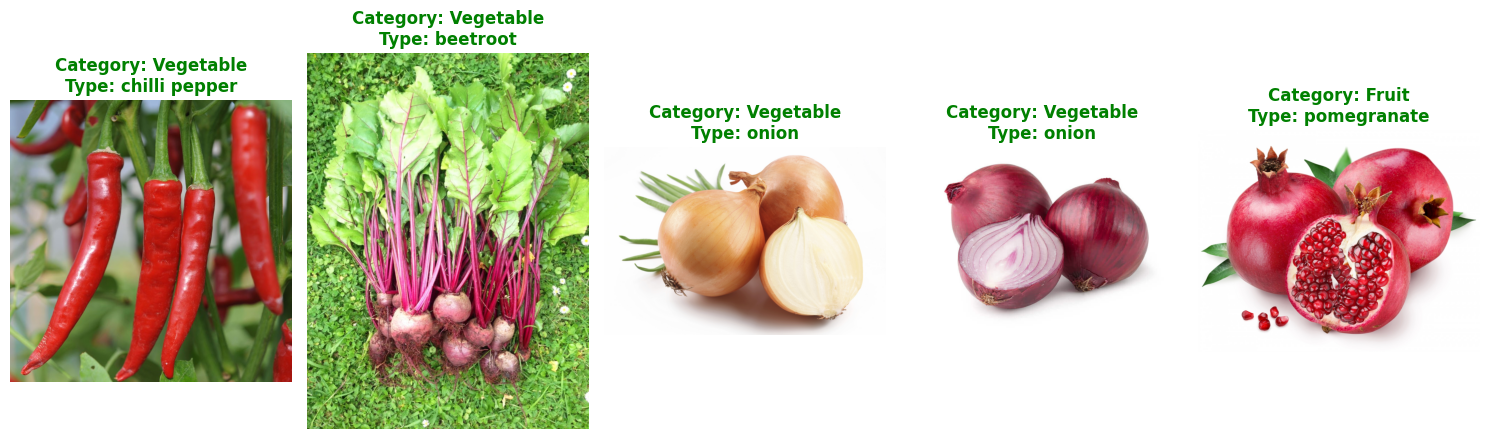

In [16]:
from PIL import Image
import matplotlib.pyplot as plt
import random
import os
import torch

def test_multiple_images(num_images=5):
    """
    Picks 'num_images' random samples, predicts them using the hierarchy,
    and displays them in a row.
    """
    
    # 1. Pick random indices
    total_images = len(test_dataset_stage1)
    indices = random.sample(range(total_images), num_images)
    
    # 2. Setup the Plot Grid
    plt.figure(figsize=(15, 5)) # Adjust width based on number of images
    
    print(f"Testing {num_images} random images...\n")

    for i, idx in enumerate(indices):
        # --- A. Get Data ---
        # Path for display
        path, _ = test_dataset_stage1.samples[idx]
        # Tensor for prediction
        img_tensor, _ = test_dataset_stage1[idx]
        
        # --- B. Prediction Logic ---
        input_tensor = img_tensor.unsqueeze(0).to(torch.float32)
        
        # 1. MobileNet Features
        with torch.no_grad():
            raw_feat = feature_extractor(input_tensor).view(1, -1).cpu().numpy()
            
        # 2. Parent Decision (Apply Parent PCA -> Parent KNN)
        # Note: Change 'knn_stage1' to 'stage1_clf' if using SVM
        parent_feat = pca_parent.transform(raw_feat)
        parent_pred = knn_stage1.predict(parent_feat)[0]
        
        cat = ""
        pred_type = ""
        
        if parent_pred == 0:
            cat = "Fruit"
            # 3. Child Decision (Apply Fruit PCA -> Fruit KNN)
            child_feat = pca_fruit.transform(raw_feat)
            local_id = knn_fruit.predict(child_feat)[0]
            pred_type = train_dataset_fruits.classes[local_id]
        else:
            cat = "Vegetable"
            # 3. Child Decision (Apply Veg PCA -> Veg KNN)
            child_feat = pca_veg.transform(raw_feat)
            local_id = knn_veg.predict(child_feat)[0]
            pred_type = train_dataset_vegs.classes[local_id]

        # --- C. Display ---
        ax = plt.subplot(1, num_images, i + 1)
        
        # Load simple image from disk
        img_display = Image.open(path)
        plt.imshow(img_display)
        plt.axis('off')
        
        # Format the text like your screenshot
        label_text = f"Category: {cat}\nType: {pred_type}"
        
        # Check if correct (Optional: Color the text green/red)
        true_name = os.path.basename(os.path.dirname(path))
        color = 'green' if pred_type == true_name else 'red'
        
        plt.title(label_text, fontsize=12, color=color, fontweight='bold')

    plt.tight_layout()
    plt.show()

# -------------------- Run It --------------------
# You can change the number to 3, 5, 10, etc.
test_multiple_images(num_images=5)